In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree



# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import os 
import sys


sys.path.append(os.path.abspath("../../src"))   
import soporte_regresion as f
pd.options.display.float_format = "{:,.2f}".format 
pd.set_option("display.max_columns", None)

In [3]:
df_encoded=pd.read_csv("../../datos/datos2/datos_nulos_minmax_encoded.csv", index_col=0).reset_index(drop=True)

In [4]:
df_encoded.head()

,price,rooms,municipality,status,floor,hasLift,size_MinMax,distance_MinMax,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,bathrooms_1,bathrooms_2,bathrooms_3
0,750.00,689.54,706.81,701.97,701.74,705.69,0.43,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
1,750.00,704.56,706.36,701.97,678.80,696.33,0.53,0.28,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
2,684.00,695.08,706.81,686.99,682.89,681.67,0.27,0.19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00
3,600.00,704.56,686.20,701.97,701.74,696.33,0.56,0.65,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
4,600.00,689.54,687.65,701.97,710.54,696.33,0.54,0.78,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


Separamos en x e y

In [5]:
x= df_encoded.drop(columns="price")
y= df_encoded[["price"]]

Separamos en train y test y le hacemos aprender

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state=42)
modelo_lineal= LinearRegression()
modelo_lineal.fit(x_train, y_train) 

LinearRegression()

Ahora hacemos la predicción

In [7]:
y_test_pred=modelo_lineal.predict(x_test)         #con esto predice un precio
y_train_pred= modelo_lineal.predict(x_train)

***K-Fold***

In [8]:
f.metricas(y_train, y_train_pred, y_test, y_test_pred)

,train,test
r2_score,0.42,0.45
MAE,30.12,30.21
MSE,"1,529.45","1,473.62"
RMSE,39.11,38.39


In [9]:
kf= KFold(n_splits=5,
          shuffle=True,
          random_state=42)

score_r2= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "r2")
np.mean(score_r2)

0.36071758205834226

In [10]:
score_mae= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_mean_absolute_error")
abs(np.mean(score_mae))

31.355648886261186

In [11]:
score_mse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_mean_squared_error")
abs(np.mean(score_mse))

1657.2151629112363

In [12]:
score_rmse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_root_mean_squared_error")
abs(np.mean(score_rmse))

40.65188730172523

In [13]:
kf= KFold(n_splits=200,
          shuffle=True,
          random_state=42)

score_r2= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "r2")
np.mean(score_r2)

nan

In [14]:
score_rmse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_root_mean_squared_error")
abs(np.mean(score_rmse))

33.839779205282355

**Como seleccionar que variables independientes eliminar si sucede over fitting**

In [15]:

df_coefs=pd.DataFrame(modelo_lineal.coef_, columns= x.columns).T
df_coefs.sort_values(by=0, key= abs, ascending=False)    #para que ordene según la importancia

,0
distance_MinMax,-65.78
bathrooms_1,-28.11
bathrooms_3,21.38
propertyType_flat,17.07
exterior_False,-10.00
exterior_True,10.00
propertyType_penthouse,-8.07
bathrooms_2,6.73
propertyType_duplex,-4.56
propertyType_studio,-4.44


### Como ya me di cuenta de que no parece ser una relación lineal paso a decision tree

**DECISION TREE**  
Separa los datos en nodos y luego hace la media en el nodo final de la variable dependiente para los datos que se encuentran en ese nodo y cuando tenga que predecir, si el dato acaba en ese nodo, se le aplicará esa media como valor de su variable dependiente.  
   
***Para elegir el mejor árbol de decisión (conformado de unas variables independientes concretas)***   
Calcula la suma de los errores al cuadrado dividido entre n del nodo final de cada arbol y compara ese error y se queda con el que tenga el error mínimo
  
- Si hay mucha profundidad, los nodos finales van a ser tan específicos que se va a dar over fitting
  
***Como decirle que pare de dividir para evitar el Over Fitting***  
- max_depth (profundida máxima del árbol)
- min_sample_split (numero de datos minimo en el nodo (madre) para que se pueda dividir)  
- min_sample_leaf (numero de datos minimo que tienen que tener los nodos(hijos) en los que me divido) 
- max_leaf_nodes (numero maximo de nodos que quiero que tenga mi arbol)  
- max_features (numero máximo de variables independientes que queremos)

Pruebo primero a ver cómo me lo hace 

In [16]:
modelo_arbol_vacio= DecisionTreeRegressor()         
modelo_arbol_vacio.fit(x_train, y_train)
y_pred_test_arb_vacio= modelo_arbol_vacio.predict(x_test)
y_pred_train_arb_vacio= modelo_arbol_vacio.predict(x_train)
df_metricas_arbol_vacio= f.metricas(y_train, y_pred_train_arb_vacio, y_test, y_pred_test_arb_vacio)
df_metricas_arbol_vacio

,train,test
r2_score,1.00,-0.29
MAE,0.00,40.59
MSE,0.00,"3,479.73"
RMSE,0.00,58.99


Dejándole a él sólo me da que se produce overfitting

In [17]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_leaf_nodes': [4, 6, 8, 10, 20, 30]
}

grid_search_arbol=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': [4, 6, 8, 10, 20, 30],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [18]:
modelo_final_arbol=grid_search_arbol.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=8, min_samples_leaf=10,
                      min_samples_split=10)

In [19]:
y_pred_test_arb= modelo_final_arbol.predict(x_test)
y_pred_train_arb= modelo_final_arbol.predict(x_train)
df_metricas_arbol= f.metricas(y_train, y_pred_train_arb, y_test, y_pred_test_arb)
df_metricas_arbol=df_metricas_arbol.T
df_metricas_arbol.reset_index(inplace=True)
df_metricas_arbol



,index,r2_score,MAE,MSE,RMSE
0,train,0.39,31.51,"1,602.90",40.04
1,test,0.12,39.11,"2,357.81",48.56


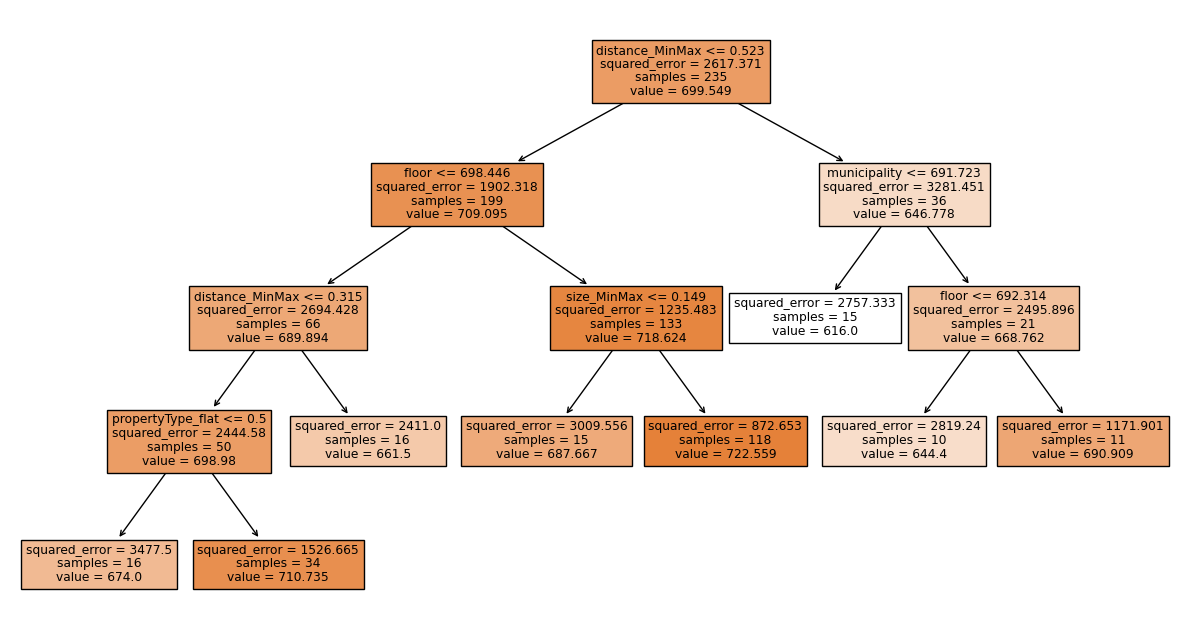

In [20]:
plt.figure(figsize=(15,8))
plot_tree(decision_tree=modelo_final_arbol, feature_names=x.columns, filled=True);

### **Este es el modelo inicial sobre el que cambiar los parametros para mejorar las métricas y por ende el modelo**

### Vamos a graficarlo porque así se entienden mejor

In [21]:
df_resultados_arbol=pd.DataFrame(grid_search_arbol.cv_results_)

In [22]:
df_resultados_arbol.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
320,0.01,0.00,0.00,0.00,10,8,10,10,"{'max_depth': 10, 'max_leaf_nodes': 8, 'min_sa...","-2,410.55","-1,703.77","-1,856.62","-2,352.37","-2,712.90","-2,207.24",372.70,1
128,0.01,0.00,0.00,0.00,5,8,10,10,"{'max_depth': 5, 'max_leaf_nodes': 8, 'min_sam...","-2,410.55","-1,703.77","-1,856.62","-2,352.37","-2,712.90","-2,207.24",372.70,1


In [23]:
df_resultados_arbol.shape   #no da el número de modelos que ha generado el árbol 

(384, 17)

In [24]:
df_resultados_arbol_filtrado=df_resultados_arbol.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado["MSE"]= df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,3,4,10,10,"-2,335.24"
1,3,4,10,50,"-2,290.83"
2,3,4,10,100,"-2,279.00"
3,3,4,10,200,"-2,634.59"
4,3,4,50,10,"-2,419.15"


In [25]:
df_rmse_profun= np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun.head()

,param_max_depth,MSE
0,3,50.31
1,5,50.30
2,7,50.32
3,10,50.32


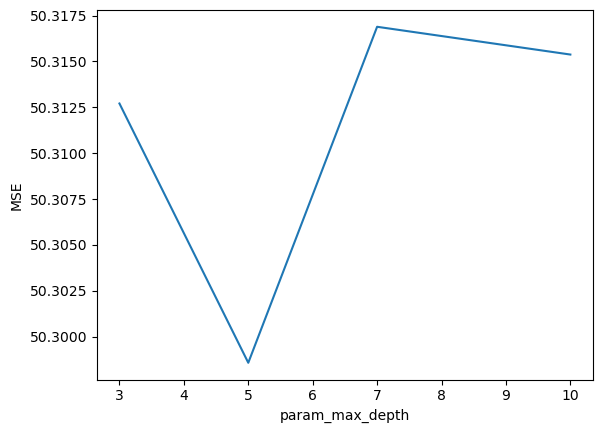

In [26]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun);

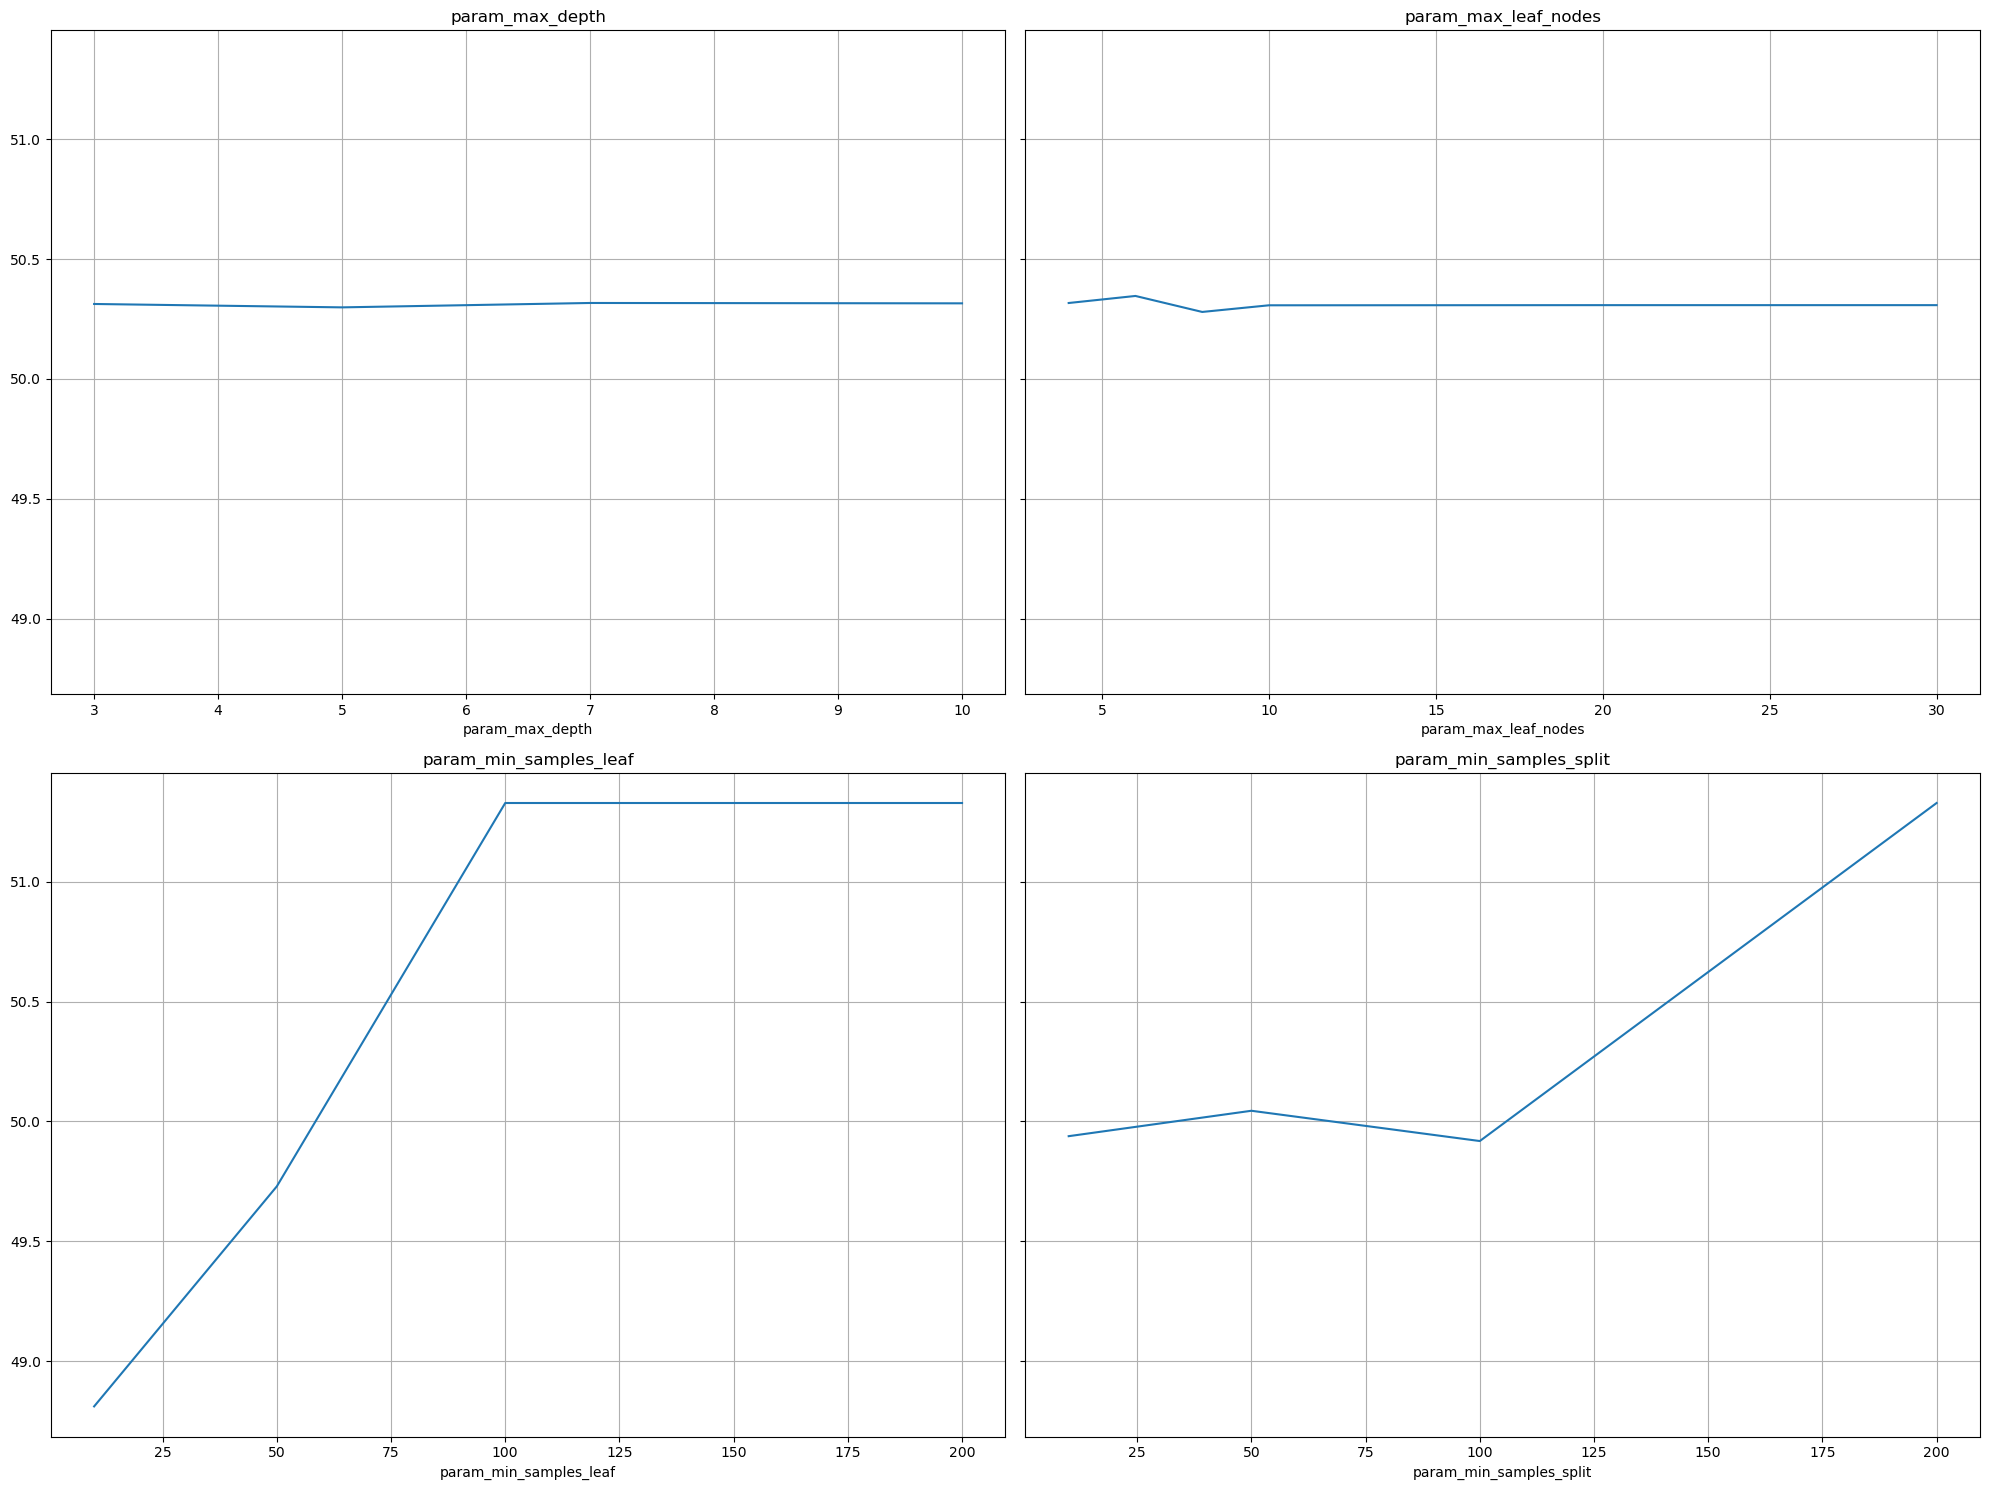

In [27]:

df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [28]:
pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False)

,Importancia
distance_MinMax,0.57
floor,0.20
municipality,0.10
size_MinMax,0.07
propertyType_flat,0.06
rooms,0.00
propertyType_studio,0.00
bathrooms_2,0.00
bathrooms_1,0.00
exterior_True,0.00


## Lo pruebo cambiando parametros

In [29]:
# Parámetros a evaluar
params_arbol_prueba = {
    'max_depth': [3,4,5,6,7,8],
    'min_samples_split': [7,8,9,10,15,25,35],
    'min_samples_leaf': [7,8,9,10,15,25,35],
    'max_leaf_nodes': [1,2,3,4,5,6,7,8,9]
}

grid_search_arbol_prueba=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol_prueba , cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol_prueba.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [7, 8, 9, 10, 15, 25, 35],
                         'min_samples_split': [7, 8, 9, 10, 15, 25, 35]},
             scoring='neg_mean_squared_error')

In [30]:
modelo_final_arbol_prueba=grid_search_arbol_prueba.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol_prueba

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=9, min_samples_leaf=7,
                      min_samples_split=7)

In [31]:
y_pred_test_arb_prueba= modelo_final_arbol_prueba.predict(x_test)
y_pred_train_arb_prueba= modelo_final_arbol_prueba.predict(x_train)
df_metricas_arbol_prueba= f.metricas(y_train, y_pred_train_arb_prueba, y_test, y_pred_test_arb_prueba)

df_metricas_arbol_prueba=df_metricas_arbol_prueba.T
df_metricas_arbol_prueba.reset_index(inplace=True)
df_metricas_arbol_prueba

,index,r2_score,MAE,MSE,RMSE
0,train,0.41,31.47,"1,547.79",39.34
1,test,0.15,38.41,"2,288.15",47.83


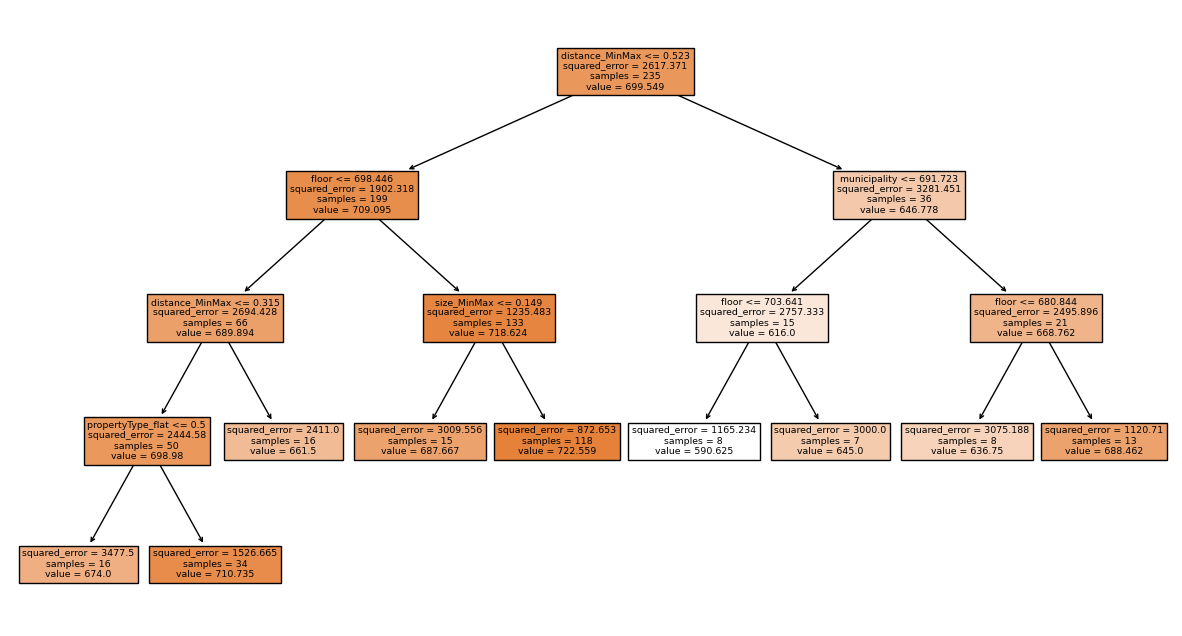

In [32]:
plt.figure(figsize=(15,8))
plot_tree(decision_tree=modelo_final_arbol_prueba, feature_names=x.columns, filled=True);

AHORA QUE SABEMOS QUE LA MEJOR DEPTH ES 60 ESTARÍA BIEN COMPARAR LA 10,11 Y 12 PARA VER SI SIGUE SIENDO LA MEJOR EL 10

### Vamos a graficarlo porque así se entienden mejor

In [33]:
df_resultados_arbol_prueba=pd.DataFrame(grid_search_arbol_prueba.cv_results_)

In [34]:
df_resultados_arbol_prueba.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
837,0.01,0.00,0.00,0.00,4,9,7,15,"{'max_depth': 4, 'max_leaf_nodes': 9, 'min_sam...","-2,187.76","-1,298.24","-2,132.09","-2,328.71","-2,725.20","-2,134.40",466.65,1
836,0.01,0.00,0.00,0.00,4,9,7,10,"{'max_depth': 4, 'max_leaf_nodes': 9, 'min_sam...","-2,187.76","-1,298.24","-2,132.09","-2,328.71","-2,725.20","-2,134.40",466.65,1


In [35]:
df_resultados_arbol_prueba.shape   #no da el número de modelos que ha generado el árbol 

(2646, 17)

In [36]:
df_resultados_arbol_filtrado_prueba=df_resultados_arbol_prueba.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado_prueba["MSE"]= df_resultados_arbol_prueba["mean_test_score"]
df_resultados_arbol_filtrado_prueba.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,3,1,7,7,NaN
1,3,1,7,8,NaN
2,3,1,7,9,NaN
3,3,1,7,10,NaN
4,3,1,7,15,NaN


In [37]:
df_rmse_profun_prueba= np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun_prueba.head()

,param_max_depth,MSE
0,3,48.25
1,4,48.14
2,5,48.14
3,6,48.14
4,7,48.14


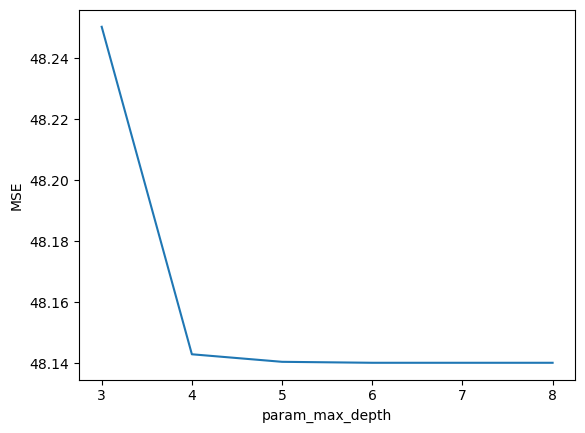

In [38]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun_prueba);

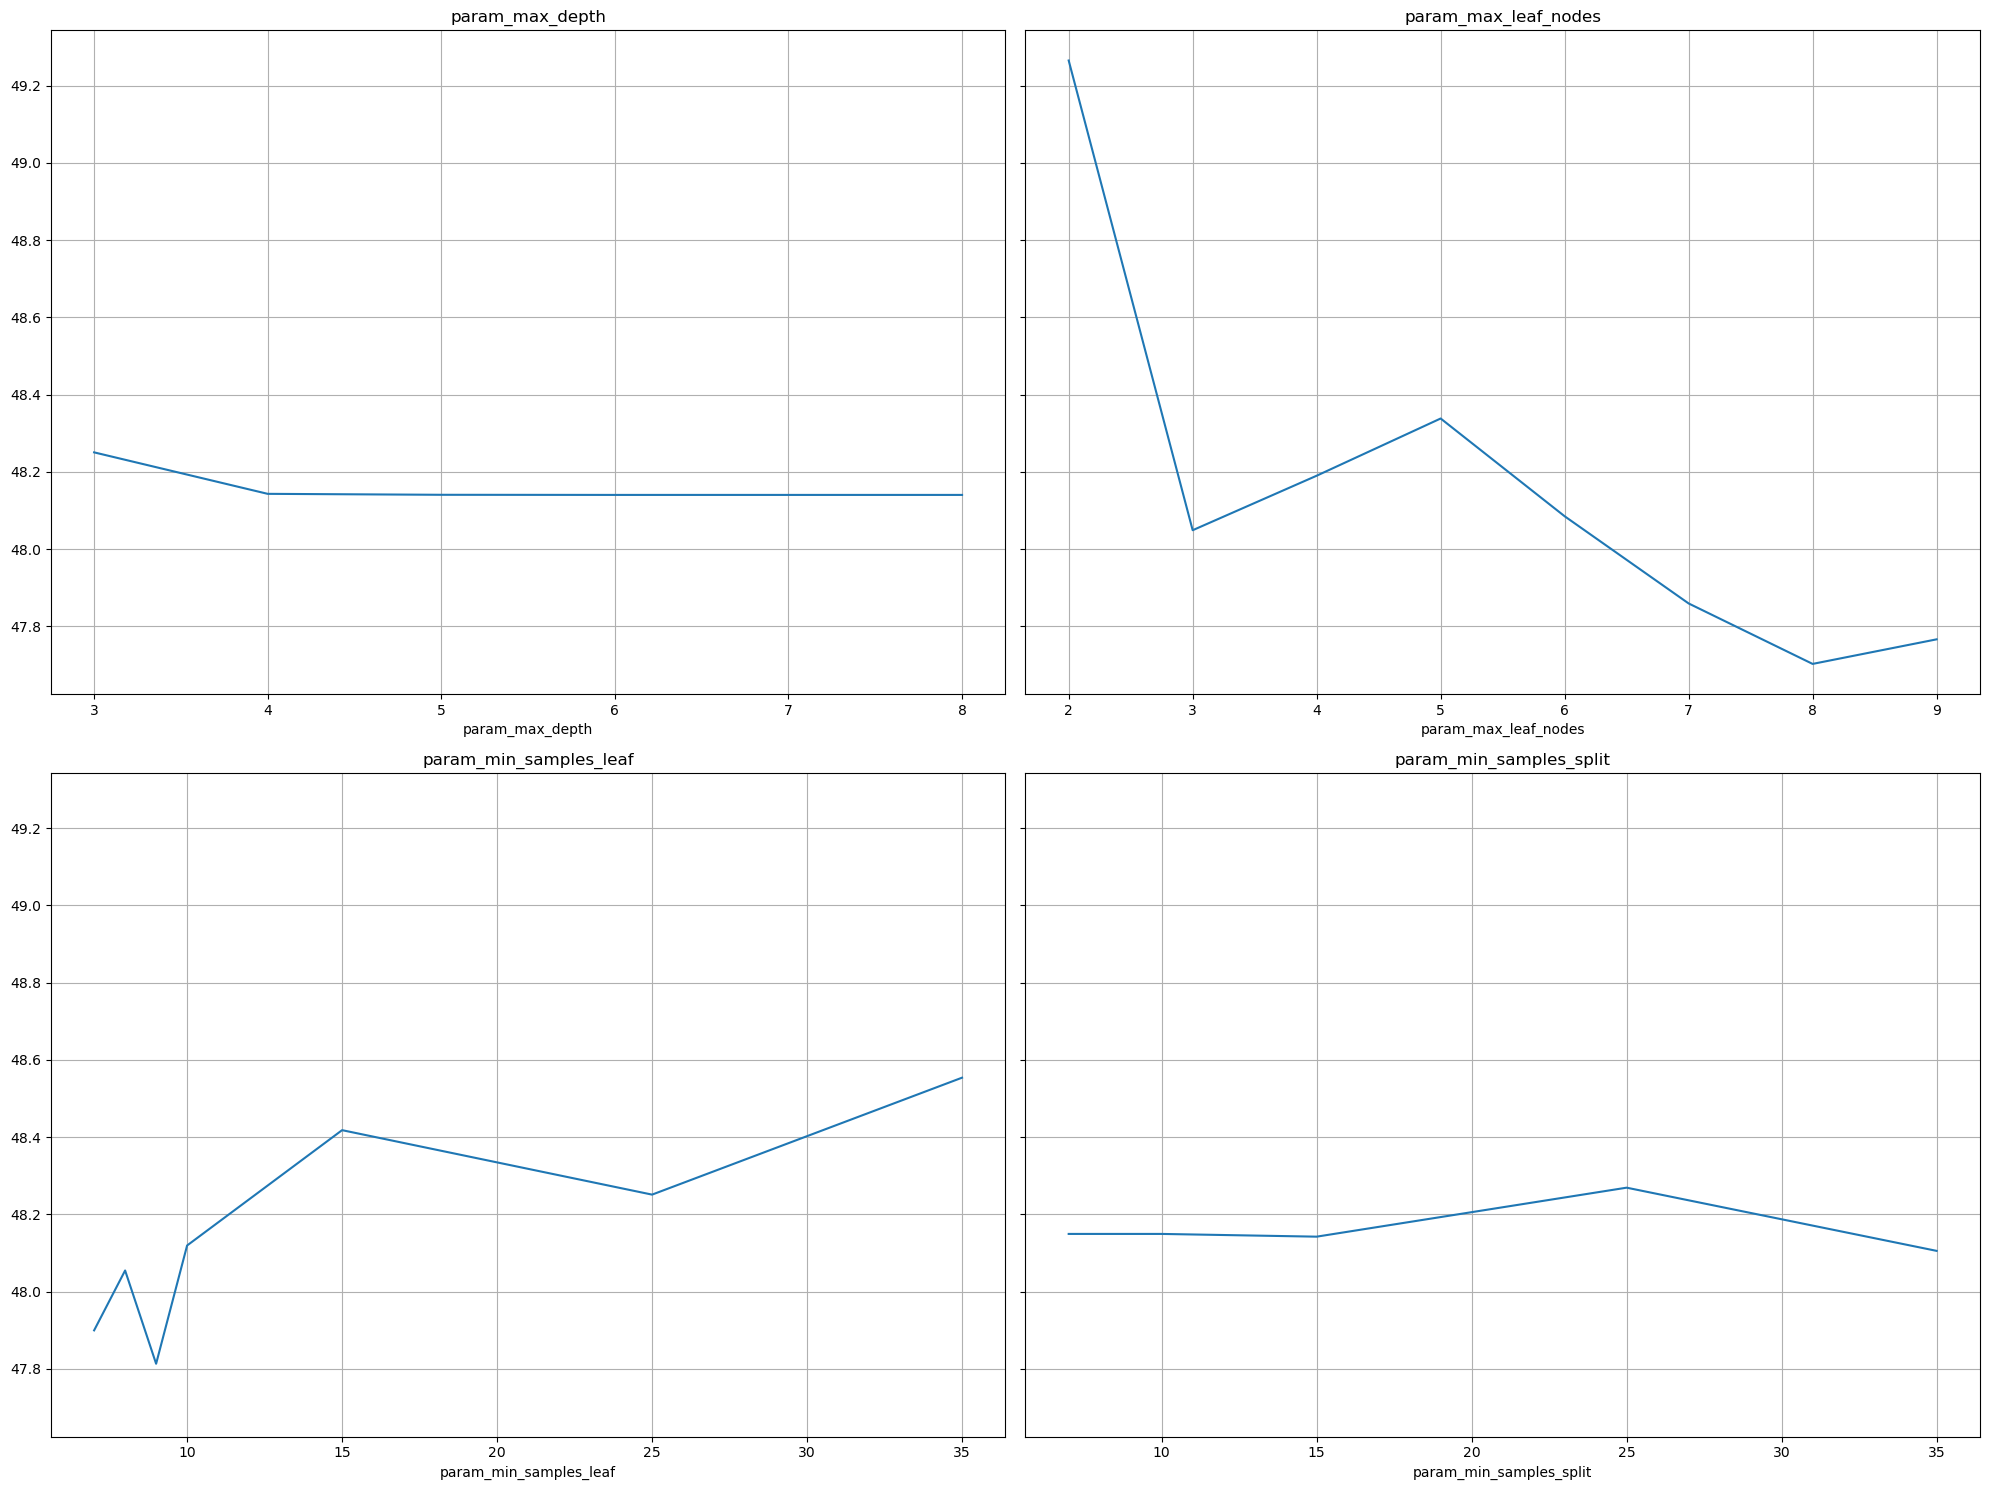

In [39]:

df_rmse_profun_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_profun_prueba = pd.DataFrame(df_rmse_profun_prueba).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado_prueba.columns[:-1]):
    df_rmse_col_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col_prueba.index, y=df_rmse_col_prueba.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [40]:
pd.DataFrame(modelo_final_arbol_prueba.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False).head()

,Importancia
distance_MinMax,0.54
floor,0.24
municipality,0.10
size_MinMax,0.06
propertyType_flat,0.06


De momento parece que mi primera opción de parámetros me da los mejores resultados.

In [41]:
# Parámetros a evaluar
params_arbolu = {
    'max_depth': [7, 8,10, 30, 50, 70, 100,200,300],
    'min_samples_split': [6,8,10,20,25,30,35,40, 50, 500, 2000],
    'min_samples_leaf': [1,3,6,7,8,10,20,30, 50, 500, 2000],
    'max_leaf_nodes': [8, 10,50, 60, 70,80,90,100,150, 200,2000]
}

grid_search_arbolu=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbolu, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbolu.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 10, 30, 50, 70, 100, 200, 300],
                         'max_leaf_nodes': [8, 10, 50, 60, 70, 80, 90, 100, 150,
                                            200, 2000],
                         'min_samples_leaf': [1, 3, 6, 7, 8, 10, 20, 30, 50,
                                              500, 2000],
                         'min_samples_split': [6, 8, 10, 20, 25, 30, 35, 40, 50,
                                               500, 2000]},
             scoring='neg_mean_squared_error')

In [42]:
modelo_final_arbolu=grid_search_arbolu.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbolu

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=8, min_samples_leaf=7,
                      min_samples_split=20)

In [43]:
y_pred_test_arbu= modelo_final_arbolu.predict(x_test)
y_pred_train_arbu= modelo_final_arbolu.predict(x_train)
df_metricas_arbolu= f.metricas(y_train, y_pred_train_arbu, y_test, y_pred_test_arbu)
df_metricas_arbolu=df_metricas_arbolu.T
df_metricas_arbolu.reset_index(inplace=True)
df_metricas_arbolu

,index,r2_score,MAE,MSE,RMSE
0,train,0.39,31.56,"1,594.76",39.93
1,test,0.16,38.56,"2,275.92",47.71


### Vamos a graficarlo porque así se entienden mejor

In [45]:
df_resultados_arbol_prueba=pd.DataFrame(grid_search_arbolu.cv_results_)

In [46]:
df_resultados_arbol_prueba.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4029,0.01,0.00,0.00,0.00,30,8,7,20,"{'max_depth': 30, 'max_leaf_nodes': 8, 'min_sa...","-2,231.10","-1,420.32","-2,017.01","-2,328.71","-2,725.20","-2,144.47",428.80,1
5360,0.01,0.00,0.01,0.00,50,8,7,20,"{'max_depth': 50, 'max_leaf_nodes': 8, 'min_sa...","-2,231.10","-1,420.32","-2,017.01","-2,328.71","-2,725.20","-2,144.47",428.80,1


In [47]:
df_resultados_arbol_prueba.shape   #no da el número de modelos que ha generado el árbol 

(11979, 17)

In [48]:
df_resultados_arbol_filtrado_prueba=df_resultados_arbol_prueba.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado_prueba["MSE"]= df_resultados_arbol_prueba["mean_test_score"]
df_resultados_arbol_filtrado_prueba.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,7,8,1,6,"-2,293.89"
1,7,8,1,8,"-2,293.89"
2,7,8,1,10,"-2,360.90"
3,7,8,1,20,"-2,319.65"
4,7,8,1,25,"-2,237.77"


In [49]:
df_rmse_profun_prueba= np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun_prueba.head()

,param_max_depth,MSE
0,7,49.48
1,8,49.51
2,10,49.61
3,30,49.64
4,50,49.65


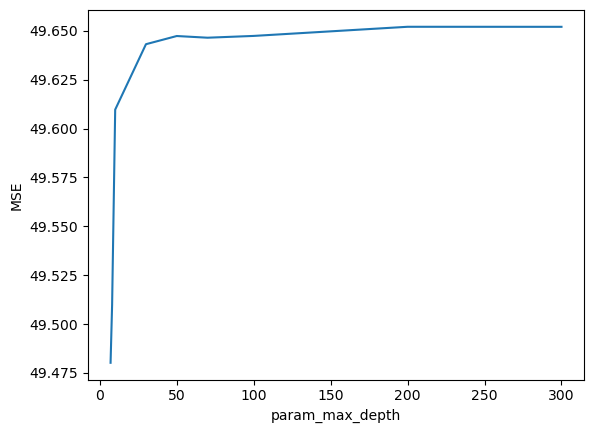

In [50]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun_prueba);

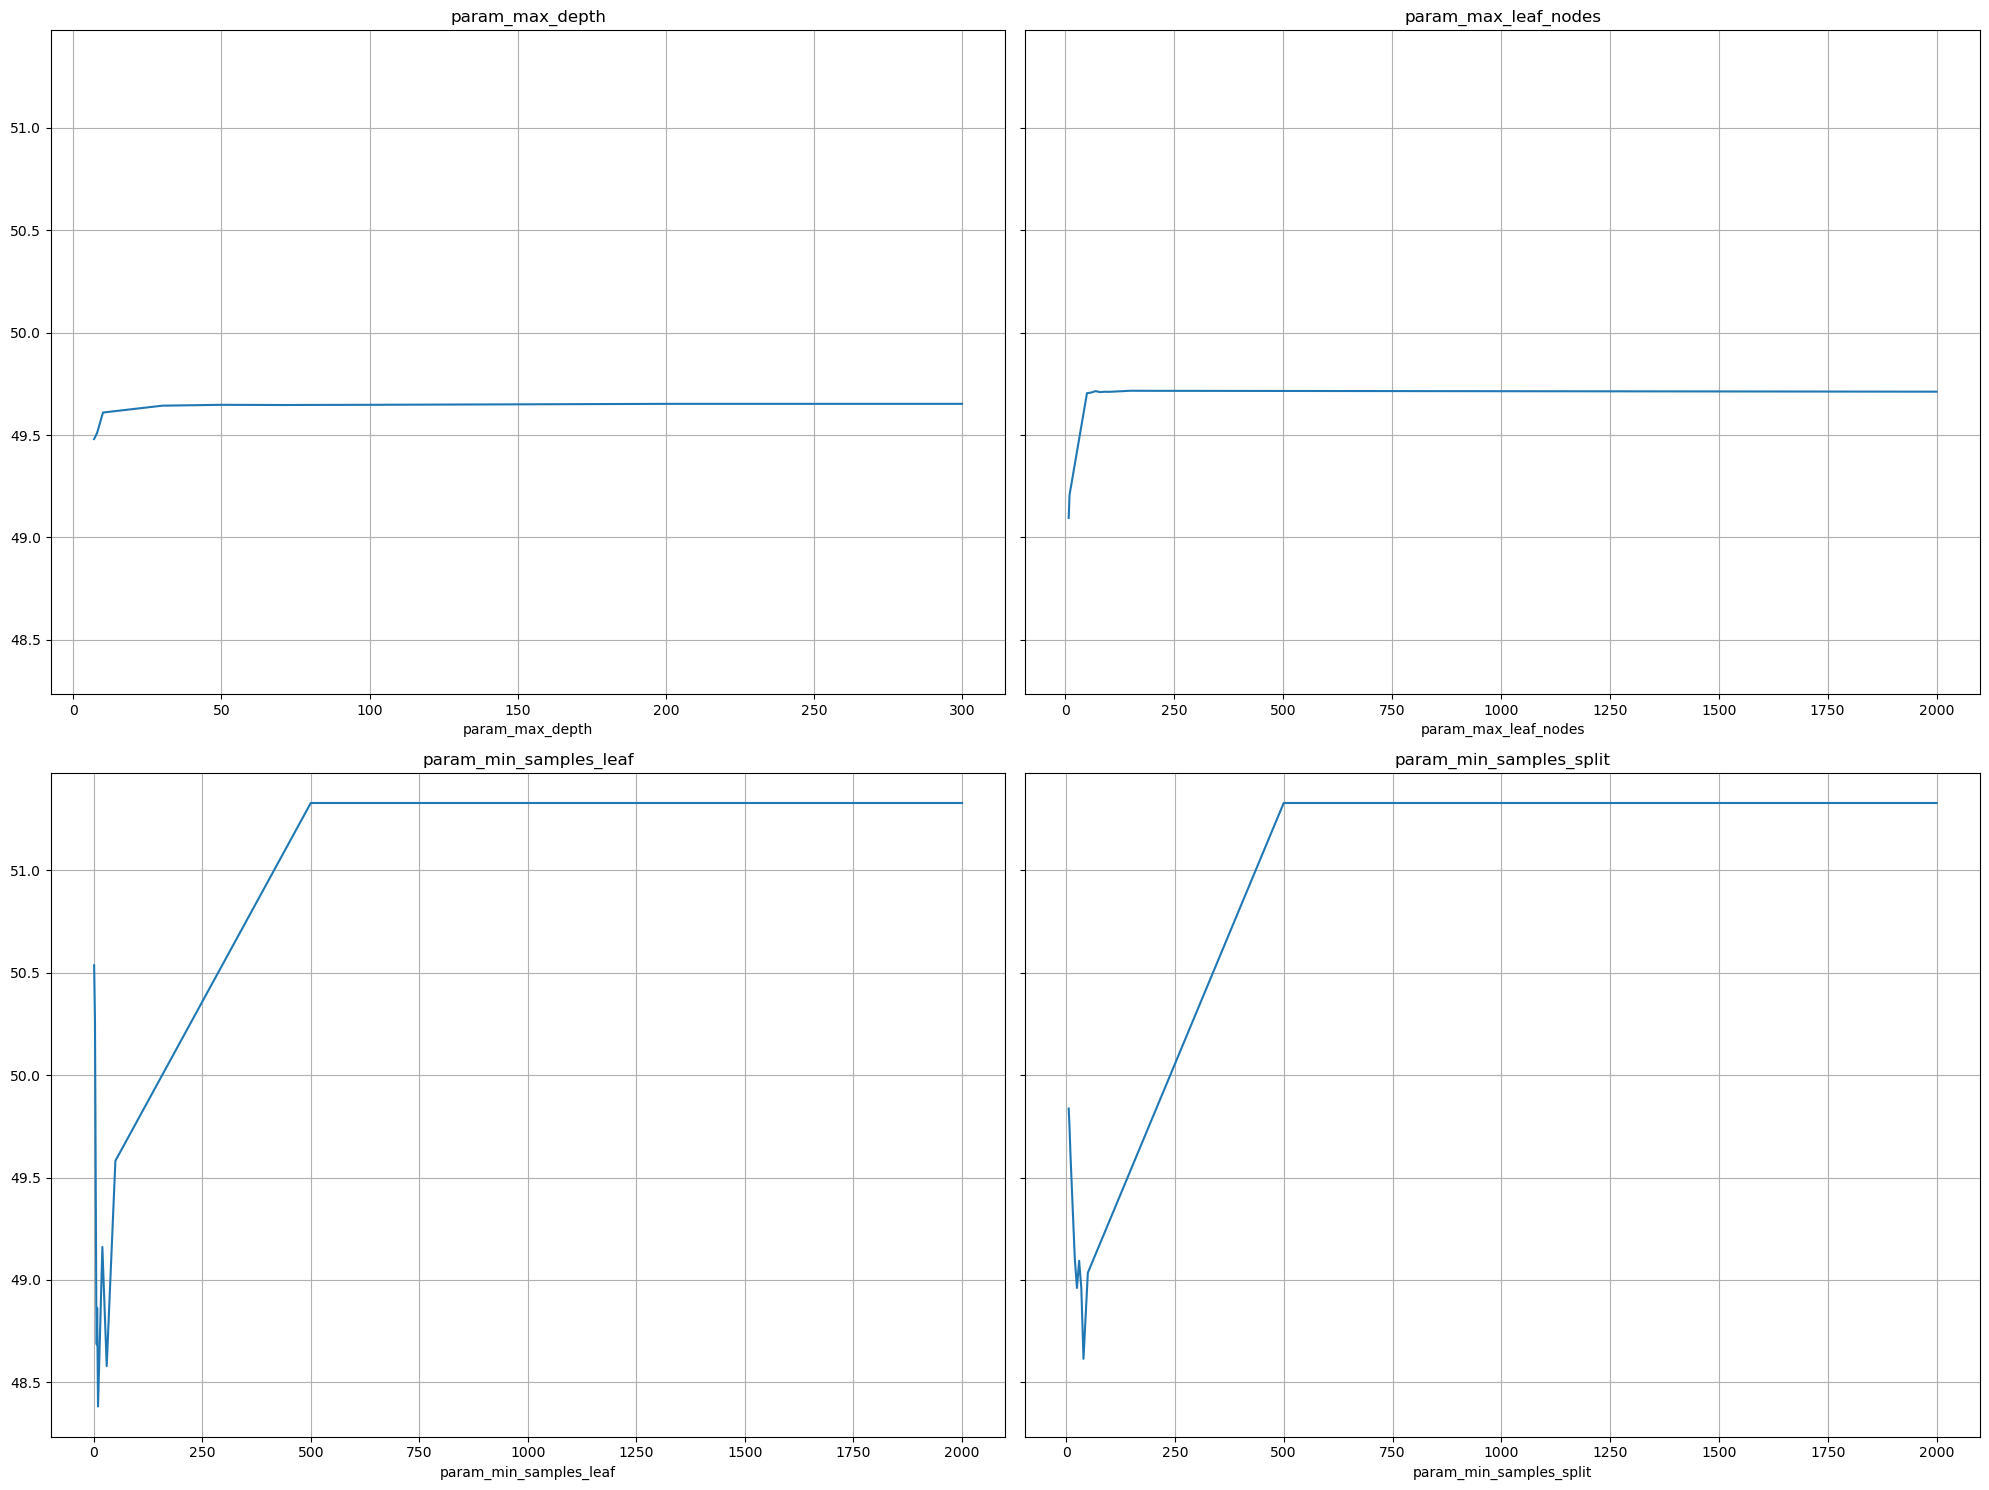

In [51]:

df_rmse_profun_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_profun_prueba = pd.DataFrame(df_rmse_profun_prueba).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado_prueba.columns[:-1]):
    df_rmse_col_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col_prueba.index, y=df_rmse_col_prueba.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [52]:
pd.DataFrame(modelo_final_arbol_prueba.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False).head()

,Importancia
distance_MinMax,0.54
floor,0.24
municipality,0.10
size_MinMax,0.06
propertyType_flat,0.06


**probamos una última combinación de parametros para el modelo**

In [53]:
# Parámetros a evaluar
params_ult = {
    'max_depth': [7],
    'min_samples_split': [30],
    'min_samples_leaf': [7],
    'max_leaf_nodes': [9]
}

grid_search_ult=GridSearchCV(DecisionTreeRegressor(), param_grid=params_ult, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_ult.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7], 'max_leaf_nodes': [9],
                         'min_samples_leaf': [7], 'min_samples_split': [30]},
             scoring='neg_mean_squared_error')

In [54]:
modelo_final_ult=grid_search_ult.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_ult

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=9, min_samples_leaf=7,
                      min_samples_split=30)

In [55]:
y_pred_test_ult= modelo_final_ult.predict(x_test)
y_pred_train_ult= modelo_final_ult.predict(x_train)
df_metricas_ult= f.metricas(y_train, y_pred_train_ult, y_test, y_pred_test_ult)
df_metricas_ult=df_metricas_ult.T
df_metricas_ult.reset_index(inplace=True)
df_metricas_ult

,index,r2_score,MAE,MSE,RMSE
0,train,0.40,30.63,"1,576.59",39.71
1,test,0.17,38.31,"2,239.00",47.32


In [56]:
pd.DataFrame(modelo_final_ult.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False).head()

,Importancia
distance_MinMax,0.55
floor,0.15
municipality,0.14
size_MinMax,0.10
propertyType_flat,0.06


PARA PODER COMPARAR MEJOR LOS MODELOS

In [57]:
dicc={0: "modelo1",
      1: "modelo1",
      2: "modelo2",
      3: "modelo2",
      4: "modelo3",
      5: "modelo3",
      6: "modelo4",
      7: "modelo4"}

In [58]:
df_final=pd.DataFrame()
df_final=pd.concat([df_final,df_metricas_arbolu, df_metricas_arbol_prueba,df_metricas_arbol,df_metricas_ult], axis=0, ignore_index=True)
df_final.reset_index(inplace=True)
df_final["level_0"]=df_final["level_0"].map(dicc)
df_final['diff_r2_score'] = df_final.groupby('level_0')['r2_score'].transform(lambda x: x.iloc[0] - x.iloc[1])
df_final['diff_RMSE'] = df_final.groupby('level_0')['RMSE'].transform(lambda x: x.iloc[0] - x.iloc[1])

df_final

,level_0,index,r2_score,MAE,MSE,RMSE,diff_r2_score,diff_RMSE
0,modelo1,train,0.39,31.56,"1,594.76",39.93,0.24,-7.77
1,modelo1,test,0.16,38.56,"2,275.92",47.71,0.24,-7.77
2,modelo2,train,0.41,31.47,"1,547.79",39.34,0.26,-8.49
3,modelo2,test,0.15,38.41,"2,288.15",47.83,0.26,-8.49
4,modelo3,train,0.39,31.51,"1,602.90",40.04,0.26,-8.52
5,modelo3,test,0.12,39.11,"2,357.81",48.56,0.26,-8.52
6,modelo4,train,0.40,30.63,"1,576.59",39.71,0.23,-7.61
7,modelo4,test,0.17,38.31,"2,239.00",47.32,0.23,-7.61


## Elección de mejor modelo:  
Comparando los modelos nos damos cuenta que el modelo mejor equilibrado es el modelo 3 (tiene metricas bastante buenas y el menor over fitting). Sin embargo, elijo quedarme con el modelo 4 que cuenta con un muy buen equilibrio también (el segundo con menos over fitting) y tiene una levemente mayor capacidad explicativa.  
  
**Finalmente me quedo con el modelo 4 correspondiente al último modelo**

In [59]:
df_metricas_ult.drop(columns= "index", inplace=True)

In [60]:
df_metricas_ulti=df_metricas_ult.T
df_metricas_ulti.columns= ["train", "test"]
df_metricas_ulti.reset_index(inplace=True)
df_metricas_ulti

,index,train,test
0,r2_score,0.40,0.17
1,MAE,30.63,38.31
2,MSE,"1,576.59","2,239.00"
3,RMSE,39.71,47.32


In [61]:
df_metricas_ulti

,index,train,test
0,r2_score,0.40,0.17
1,MAE,30.63,38.31
2,MSE,"1,576.59","2,239.00"
3,RMSE,39.71,47.32


Vamos a intentar visualizar las cositas

In [62]:
predytest=pd.DataFrame(y_pred_test_ult, columns=["y_pred_test_ult"])

In [63]:
predytrain=pd.DataFrame(y_pred_train_ult, columns=["y_pred_train_ult"])

In [64]:
df_fin=pd.DataFrame()
df_fin=pd.concat([df_fin, predytest, predytrain, y], ignore_index=True, axis=1)

In [65]:
df_fin.columns= ["test_prediccion", "train_prediccion", "precio_original"]

In [66]:
df_fin.reset_index(inplace=True)

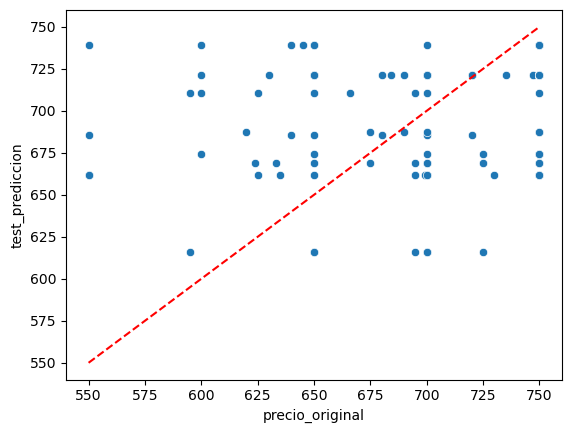

In [67]:
sns.scatterplot(x="precio_original", y="test_prediccion", data= df_fin)
plt.plot([df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         [df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         color='red', linestyle='--', label='x = y')

***CONCLUSIONES DE ESTE MODELO 4 PARA INTENTAR MEJORAR***  
  
- Este modelo 4 me predice mal los precios 400-550 aproximadamente (me predice las viviendas baratas como caras)  y un poco los precios de 650-750 (algunas viviendas caras me las predice como baratas)  
